# Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, plot_confusion_matrix
import pickle

# Data reading

In [3]:
df = pd.read_csv(r"C:\Users\hp\Downloads\transaction_dataset.csv\transaction_dataset.csv", index_col=0)
print(df.shape)
df.head()

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [4]:
# Ommit first two columns (Index, Adress)
df = df.iloc[:,2:]

# Data information & exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 48 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841 non-

In [7]:
# Turn object variables into 'category' dtype for more computation efficiency
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,ERC20 most sent token type,ERC20_most_rec_token_type
0,Cofoundit,Numeraire
1,Livepeer Token,Livepeer Token
2,NaN,XENON
3,Raiden,XENON
4,StatusNetwork,EOS
...,...,...
9836,,GSENetwork
9837,,Blockwell say NOTSAFU
9838,,Free BOB Tokens - BobsRepair.com
9839,NaN,NaN


In [6]:
for i in df[categories].columns:
  print(f'The categorical column --{i}-- has --{len(df[i].value_counts())}-- unique values')

The categorical column -- ERC20 most sent token type-- has --305-- unique values
The categorical column -- ERC20_most_rec_token_type-- has --467-- unique values


In [7]:
numericals = df.select_dtypes(include=['float','int']).columns
df[numericals].describe()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 avg time between sent tnx,ERC20 avg time between rec tnx,ERC20 avg time between rec 2 tnx,ERC20 avg time between contract tnx,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9.841000e+03,9.841000e+03,9841.000000,9.841000e+03,9012.000000,9.012000e+03,9.012000e+03,9012.000000,9012.000000,9012.000000,9012.000000,9012.000000,9012.0,9012.0,9012.0,9012.0,9012.000000,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,523.152481,100.711721,4.800090,314.617297,44.755731,0.000003,0.000008,0.000005,283.362362,1.016092e+04,1.163832e+04,0.000008,1.477395e+03,36.255659,1.296207e+08,1.386849e+07,110.939207,5.638038,7.598535,0.003440,4.901909,0.0,0.0,0.0,0.0,485.614688,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,13008.821539,2885.002236,138.609682,6629.212643,239.080215,0.000225,0.000516,0.000323,1352.404013,3.583227e+05,3.642048e+05,0.000516,2.424254e+05,447.528908,1.053858e+10,1.180390e+09,6128.634953,105.252500,81.818470,0.065698,17.246576,0.0,0.0,0.0,0.0,16883.278712,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.560535e+07,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,1.000000,0.426905,0.000000,0.164577,0.086184,0.000000,0.000000,0.000000,4.000000,2.262059e-01,2.670424e+00,0.000000,6.214900e-04,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,6.000000,1.729730,0.049126,4.999380,1.606000,0.000000,0.000000,0.000000,8.000000,1.248680e+01,3.052963e+01,0.000000,1.722000e-03,1.000000,1.000000e-12,0.000000e+00,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,67.067040,22.000000,0.998800,61.520653,21.999380,0.000

In [8]:
df[numericals].var()

FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062298e+05
max value received                                      1.692294e+08
avg val received                                        8.323238e+06
min val sent                                            1.921264e+04
max val sent                                            4.394646e+07
avg val sent                      

0    7662
1    2179
Name: FLAG, dtype: int64


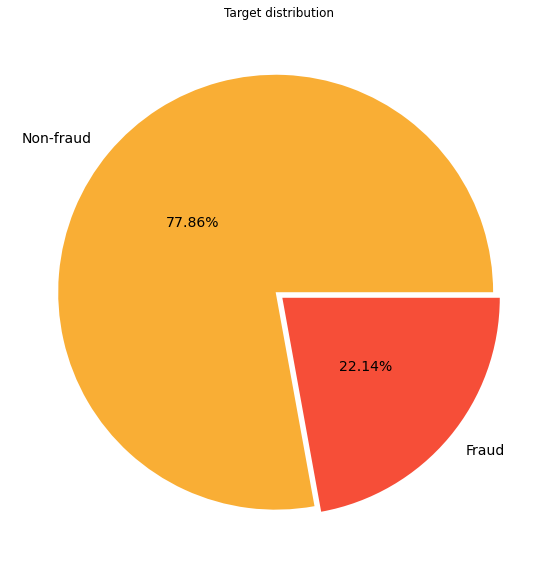

In [9]:
print(df['FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

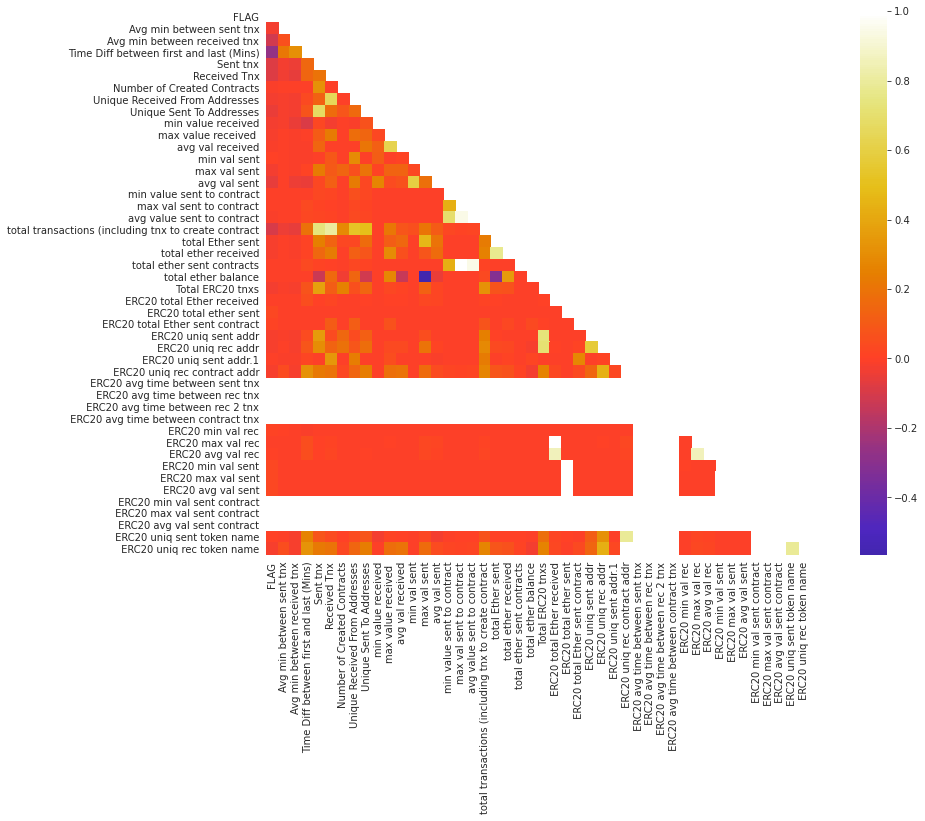

In [10]:
# Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize=(18,10))
  sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)

# Data cleaning

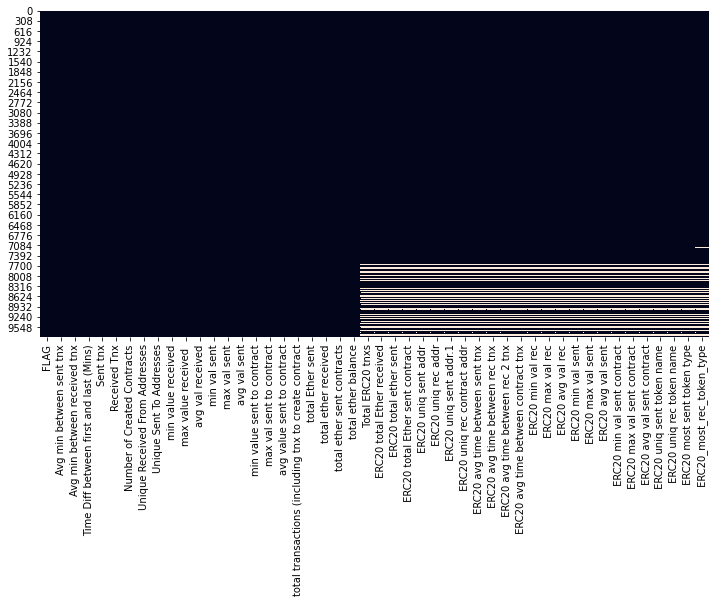

In [11]:
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [12]:
# Drop the two categorical features
df.drop(df[categories], axis=1, inplace=True)

In [13]:
# Replace missings of numerical variables with median
df.fillna(df.median(), inplace=True)

(9841, 46)


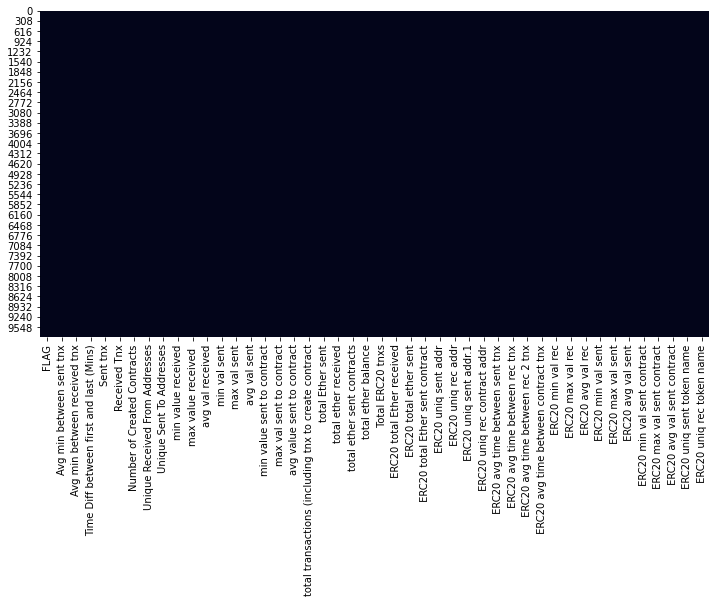

In [14]:
# Visualize missings pattern of the dataframe
print(df.shape)
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

Investigating the variance of the features, it was observed that there are some features with a variance = 0

In [15]:
# Filtering the features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print(df.var())
print(df.shape)

 ERC20 avg time between sent tnx        0.0
 ERC20 avg time between rec tnx         0.0
 ERC20 avg time between rec 2 tnx       0.0
 ERC20 avg time between contract tnx    0.0
 ERC20 min val sent contract            0.0
 ERC20 max val sent contract            0.0
 ERC20 avg val sent contract            0.0
dtype: float64


FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                    

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9841 entries, 0 to 9840
Data columns (total 39 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841

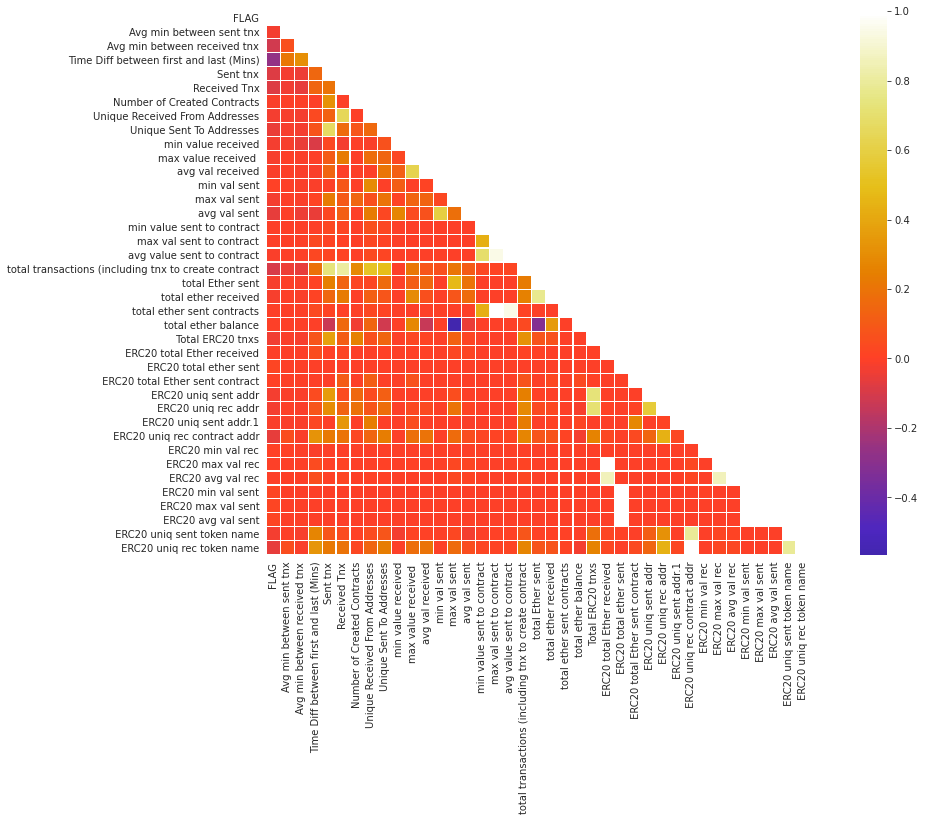

In [16]:
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize=(18,10))
  sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

Drop one of those highly correlated features
    


In [17]:
drop = ['total transactions (including tnx to create contract', 'total ether sent contracts', 'max val sent to contract', ' ERC20 avg val rec',
        ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', 'max val sent', ' ERC20 avg val sent',
        ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', 'avg value sent to contract', 'Unique Sent To Addresses',
        'Unique Received From Addresses', 'total ether received', ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr' ]
df.drop(drop, axis=1, inplace=True)

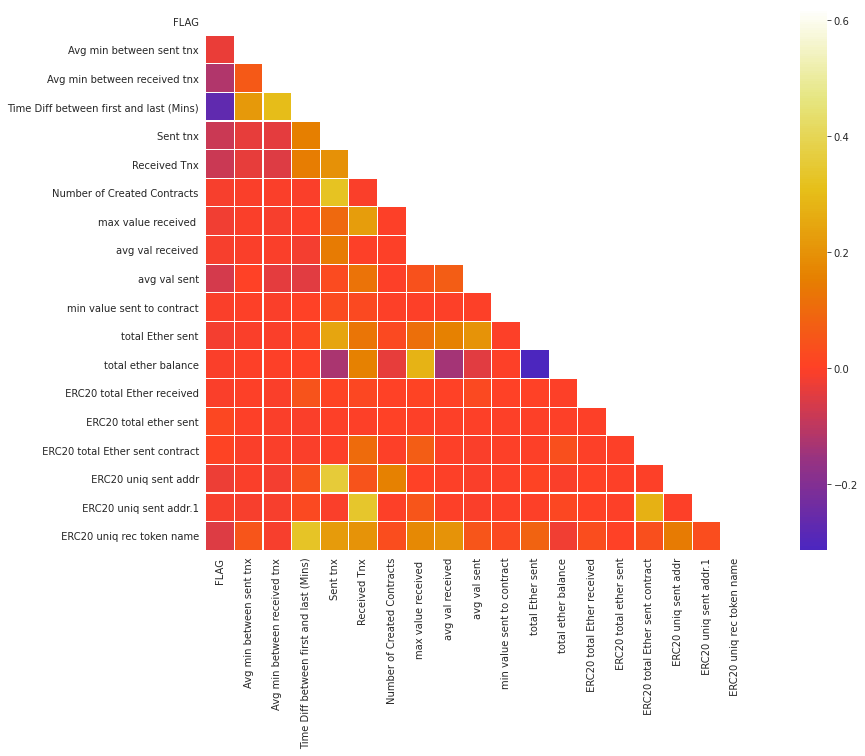

In [18]:
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize=(18,10))
  sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

In [19]:
columns = df.columns
columns

Index(['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Created Contracts', 'max value received ',
       'avg val received', 'avg val sent', 'min value sent to contract',
       'total Ether sent', 'total ether balance',
       ' ERC20 total Ether received', ' ERC20 total ether sent',
       ' ERC20 total Ether sent contract', ' ERC20 uniq sent addr',
       ' ERC20 uniq sent addr.1', ' ERC20 uniq rec token name'],
      dtype='object')

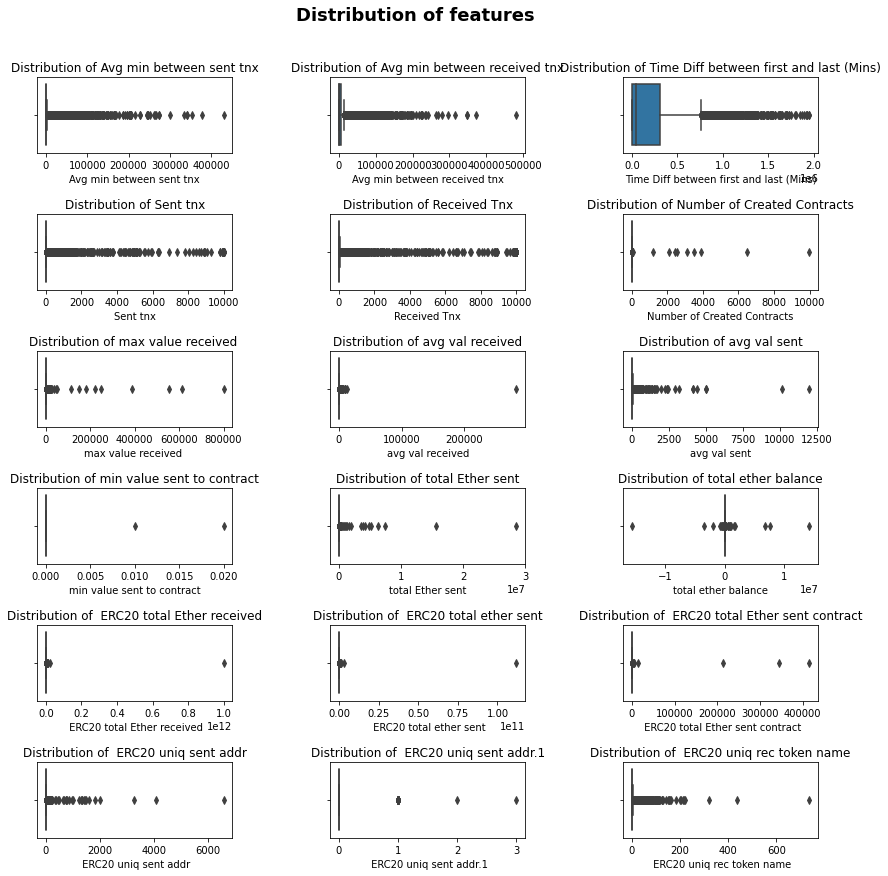

In [21]:
# Investigate the distribution of our features using boxplots
b=20

fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.5, hspace=0.8)
plt.suptitle("Distribution of features",y=0.95, size=18, weight='bold')

ax = sns.boxplot(ax = axes[0,0], data=df, x=columns[1])
ax.set_title(f'Distribution of {columns[1]}')

ax1 = sns.boxplot(ax = axes[0,1], data=df, x=columns[2])
ax1.set_title(f'Distribution of {columns[2]}')

ax2 = sns.boxplot(ax = axes[0,2], data=df, x=columns[3])
ax2.set_title(f'Distribution of {columns[3]}')

ax3 = sns.boxplot(ax = axes[1,0], data=df, x=columns[4])
ax3.set_title(f'Distribution of {columns[4]}')

ax4 = sns.boxplot(ax = axes[1,1], data=df, x=columns[5])
ax4.set_title(f'Distribution of {columns[5]}')

ax5 = sns.boxplot(ax = axes[1,2], data=df, x=columns[6])
ax5.set_title(f'Distribution of {columns[6]}')

ax6 = sns.boxplot(ax = axes[2,0], data=df, x=columns[7])
ax6.set_title(f'Distribution of {columns[7]}')

ax7 = sns.boxplot(ax = axes[2,1], data=df, x=columns[8])
ax7.set_title(f'Distribution of {columns[8]}')

ax8 = sns.boxplot(ax = axes[2,2], data=df, x=columns[9])
ax8.set_title(f'Distribution of {columns[9]}')

ax9 = sns.boxplot(ax = axes[3,0], data=df, x=columns[10])
ax9.set_title(f'Distribution of {columns[10]}')
 
ax10 = sns.boxplot(ax = axes[3,1], data=df, x=columns[11])
ax10.set_title(f'Distribution of {columns[11]}')

ax11 = sns.boxplot(ax = axes[3,2], data=df, x=columns[12])
ax11.set_title(f'Distribution of {columns[12]}')
 
ax12 = sns.boxplot(ax = axes[4,0], data=df, x=columns[13])
ax12.set_title(f'Distribution of {columns[13]}')
 
ax13 = sns.boxplot(ax = axes[4,1], data=df, x=columns[14])
ax13.set_title(f'Distribution of {columns[14]}')
 
ax14 = sns.boxplot(ax = axes[4,2], data=df, x=columns[15])
ax14.set_title(f'Distribution of {columns[15]}')
 
ax15 = sns.boxplot(ax = axes[5,0], data=df, x=columns[16])
ax15.set_title(f'Distribution of {columns[16]}')
 
ax16 = sns.boxplot(ax = axes[5,1], data=df, x=columns[17])
ax16.set_title(f'Distribution of {columns[17]}')
 
ax17 = sns.boxplot(ax = axes[5,2], data=df, x=columns[18])
ax17.set_title(f'Distribution of {columns[18]}')

plt.show()

In [22]:
# Some features present a small distribution
for i in df.columns[1:]:
  if len(df[i].value_counts()) < 10:
    print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
    print('======================================')

The column min value sent to contract has the following distribution: 
0.00    9839
0.02       1
0.01       1
Name: min value sent to contract, dtype: int64
The column  ERC20 uniq sent addr.1 has the following distribution: 
0.0    9813
1.0      26
2.0       1
3.0       1
Name:  ERC20 uniq sent addr.1, dtype: int64


It can be observed that the values of these two variables are mosty 0s. Thus, both features will be discarded since they will not be helpful for our model

In [23]:
drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']
df.drop(drops, axis=1, inplace=True)
print(df.shape)
df.head()

(9841, 17)


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,0,844.26,1093.71,704785.63,721,89,0,45.806785,6.589513,1.200681,865.691093,-279.224419,3.558854e+07,3.560317e+07,0.0,30.0,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,2.613269,0.385685,0.032844,3.087297,-0.001819,4.034283e+02,2.260809e+00,0.0,1.0,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,1.165453,0.358906,1.794308,3.588616,0.000441,5.215121e+02,0.000000e+00,0.0,0.0,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,500.000000,99.488840,70.001834,1750.045862,-854.646303,1.711105e+04,1.141223e+04,0.0,2.0,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,12.802411,2.671095,0.022688,104.318883,-50.896986,1.628297e+05,1.235399e+05,0.0,4.0,27.0


# Data preparation

In [24]:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape, y.shape)

(9841, 16) (9841,)


In [25]:
# Split into training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7872, 16) (7872,)
(1969, 16) (1969,)


In [26]:
# Normalize the training features
norm = PowerTransformer()
norm_train_f = norm.fit_transform(X_train)

In [42]:
norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)
norm_df

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,1.294061,1.151313,1.393751,1.591951,1.017881,-0.401539,1.170696,0.988757,0.651223,1.416308,-0.007274,1.815951,2.508169,-0.038483,2.398649,1.831406
1,-1.096066,-1.184221,-1.638410,-1.391726,-1.785005,-0.401539,-1.407378,-1.283886,-1.138468,-1.252291,-0.006836,-0.746114,-0.410600,-0.038483,-0.437145,0.226082
2,-0.006354,0.213137,1.103220,1.970707,1.876994,-0.401539,0.613575,-0.995919,-0.869934,1.171479,-0.006819,-0.746114,-0.410600,-0.038483,-0.437145,-0.994019
3,-1.096066,1.220438,0.195684,-1.391726,-0.618856,2.490307,-0.871196,-0.822389,-1.138468,-1.252291,-0.006832,-0.746114,-0.410600,-0.038483,-0.437145,-0.994019
4,0.628503,-1.121221,-0.904665,-0.206187,-0.618856,-0.401539,0.889875,1.277099,1.332663,0.787323,-0.006836,-0.746114,-0.410600,-0.038483,-0.437145,-0.994019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7867,-1.096066,0.249518,-0.705997,-0.590325,-0.618856,-0.401539,-0.535113,-0.269750,0.183532,-0.463079,-0.006836,-0.746114,-0.410600,-0.038483,-0.437145,0.226082
7868,1.128623,0.633621,0.895636,0.707356,1.432439,-0.401539,0.339924,-0.354586,1.043745,1.010645,-0.006835,1.611838,-0.410600,-0.038483,-0.437145,1.238838
7869,-1.096066,-1.184221,-1.154101,-0.590325,-1.004903,-0.401539,-1.275895,-1.091970,-0.960939,-1.159157,-0.006835,-0.746114,-0.410600,-0.038483,-0.437145,-0.994019
7870,1.385084,0.988959,0.715180,0.707356,0.556810,-0.401539,1.858790,1.531808,1.671553,1.592460,-0.006835,1.514388,-0.410600,-0.038483,-0.437145,1.122262


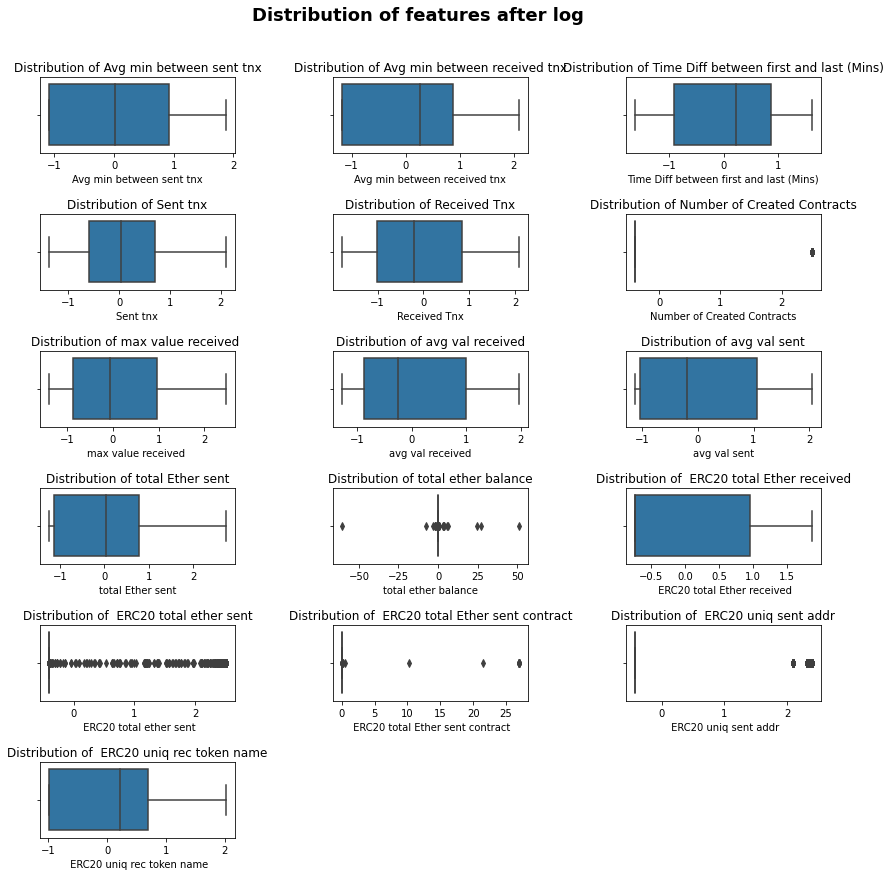

In [46]:
# Distribution of features after log transformation

b=20

fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.5, hspace=0.8)
axes[-1, -1].axis('off') # hide axes
axes[-1, -2].axis('off') # hide axes
plt.suptitle("Distribution of features after log",y=0.95, family='Sherif', size=18, weight='bold')
 
ax = sns.boxplot(ax = axes[0,0], data=norm_df, x=norm_df.columns[0])
ax.set_title(f'Distribution of {norm_df.columns[0]}')
 
ax1 = sns.boxplot(ax = axes[0,1], data=norm_df, x=norm_df.columns[1])
ax1.set_title(f'Distribution of {norm_df.columns[1]}')
 
ax2 = sns.boxplot(ax = axes[0,2], data=norm_df, x=norm_df.columns[2])
ax2.set_title(f'Distribution of {norm_df.columns[2]}')
 
ax3 = sns.boxplot(ax = axes[1,0], data=norm_df, x=norm_df.columns[3])
ax3.set_title(f'Distribution of {norm_df.columns[3]}')
 
ax4 = sns.boxplot(ax = axes[1,1], data=norm_df, x=norm_df.columns[4])
ax4.set_title(f'Distribution of {norm_df.columns[4]}')
 
ax5 = sns.boxplot(ax = axes[1,2], data=norm_df, x=norm_df.columns[5])
ax5.set_title(f'Distribution of {norm_df.columns[5]}')
 
ax6 = sns.boxplot(ax = axes[2,0], data=norm_df, x=norm_df.columns[6])
ax6.set_title(f'Distribution of {norm_df.columns[6]}')
 
ax7 = sns.boxplot(ax = axes[2,1], data=norm_df, x=norm_df.columns[7])
ax7.set_title(f'Distribution of {norm_df.columns[7]}')
 
ax8 = sns.boxplot(ax = axes[2,2], data=norm_df, x=norm_df.columns[8])
ax8.set_title(f'Distribution of {norm_df.columns[8]}')
 
ax9 = sns.boxplot(ax = axes[3,0], data=norm_df, x=norm_df.columns[9])
ax9.set_title(f'Distribution of {norm_df.columns[9]}')

ax10 = sns.boxplot(ax = axes[3,1], data=norm_df, x=norm_df.columns[10])
ax10.set_title(f'Distribution of {norm_df.columns[10]}')
 
ax11 = sns.boxplot(ax = axes[3,2], data=norm_df, x=norm_df.columns[11])
ax11.set_title(f'Distribution of {norm_df.columns[11]}')
 
ax12 = sns.boxplot(ax = axes[4,0], data=norm_df, x=norm_df.columns[12])
ax12.set_title(f'Distribution of {norm_df.columns[12]}')
 
ax13 = sns.boxplot(ax = axes[4,1], data=norm_df, x=norm_df.columns[13])
ax13.set_title(f'Distribution of {norm_df.columns[13]}')
 
ax14 = sns.boxplot(ax = axes[4,2], data=norm_df, x=norm_df.columns[14])
ax14.set_title(f'Distribution of {norm_df.columns[14]}')
 
ax15 = sns.boxplot(ax = axes[5,0], data=norm_df, x=norm_df.columns[15])
ax15.set_title(f'Distribution of {norm_df.columns[15]}')

plt.show()

# Handling the imbalance
Oversampling using SMOTE

In [56]:
oversample = SMOTE()
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((7872, 16), (7872,))
Shape of the training after SMOTE: ((12230, 16), (12230,))


In [30]:
# Target distribution before SMOTE
non_fraud = 0
fraud = 0

for i in y_train:
  if i == 0:
    non_fraud +=1
  else:
    fraud +=1

# Target distribution after SMOTE
no = 0
yes = 1

for j in y_tr_resample:
  if j == 0:
    no +=1
  else:
    yes +=1


print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFauds: {fraud}')
print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFauds: {yes}')

BEFORE OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 1757
AFTER OVERSAMPLING 
 	Non-frauds: 6115 
 	Fauds: 6116


# Modeling


## Logistic regression

In [31]:
LR = LogisticRegression(random_state=42)
LR.fit(x_tr_resample, y_tr_resample)

# Transform test features
norm_test_f = norm.transform(X_test)

preds = LR.predict(norm_test_f)

In [32]:
print(y_test.shape)
y_test.value_counts()

(1969,)


0    1547
1     422
Name: FLAG, dtype: int64

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      1547
           1       0.58      0.94      0.72       422

    accuracy                           0.84      1969
   macro avg       0.78      0.88      0.80      1969
weighted avg       0.89      0.84      0.85      1969

[[1262  285]
 [  27  395]]


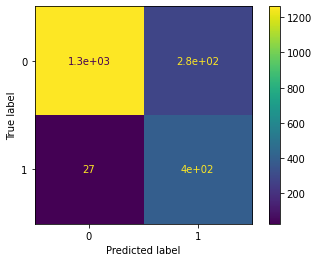

In [33]:
print(classification_report(y_test, preds))
print(confusion_matrix(y_test, preds))
plot_confusion_matrix(LR, norm_test_f, y_test)

Considering the confusion matrix:
 - LR model, correctly identified 395 (TP) of FRAUD cases, out of 422 (P).
 - LR model flagged as FRAUD 285 (FP) out of 1547, when this cases were actually NON-FRAUD
 

Dealing with a fraud detection scenario, we care more about the transactions that were actualy FRAUDS, but which were treated as NON-FRAUD by our model (FN - 27) TYPE II ERROR

Therby, let's try to increase the precision using other methods.


## Random Forest Classifier

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1547
           1       0.91      0.96      0.94       422

    accuracy                           0.97      1969
   macro avg       0.95      0.97      0.96      1969
weighted avg       0.97      0.97      0.97      1969

[[1507   40]
 [  16  406]]


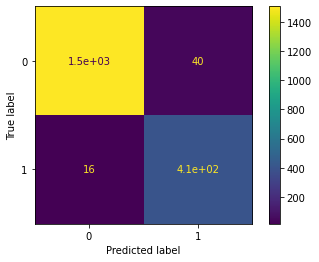

In [34]:
RF = RandomForestClassifier(random_state=42)
RF.fit(x_tr_resample, y_tr_resample)
preds_RF = RF.predict(norm_test_f)

print(classification_report(y_test, preds_RF))
print(confusion_matrix(y_test, preds_RF))
plot_confusion_matrix(RF, norm_test_f, y_test)

The RF classifier seems to produce more efective results
 - Both FP and FN are reduced considerably increasing the recal & precision
 - Using RF, the model fails to detect 16 FRAUD cases. 


Let's see if we can increase these results.

## XGBClassifier

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1547
           1       0.79      0.98      0.88       422

    accuracy                           0.94      1969
   macro avg       0.89      0.96      0.92      1969
weighted avg       0.95      0.94      0.94      1969

[[1437  110]
 [   7  415]]


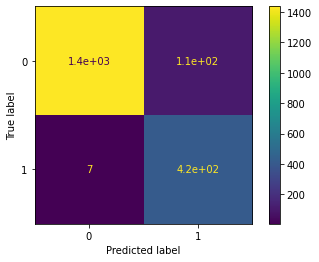

In [49]:
xgb_c = xgb.XGBClassifier(seed=42)
xgb_c.fit(x_tr_resample, y_tr_resample)
preds_xgb = xgb_c.predict(norm_test_f)

print(classification_report(y_test, preds_xgb))
print(confusion_matrix(y_test, preds_xgb))
plot_confusion_matrix(xgb_c, norm_test_f, y_test)

The results of XGBClassifier shows that its doing worse than the RF when it comes to NON-FRAUD transactions, flagging 110 cases as fraud when they were actually non-fraud.


On the other hand, when it comes to identifiying FRAUDS, XGBClassifier only misses 7 transactions out of 422, suggesting the best recall score.

Considering that, the XGBClassifier is the choice that we want.

Let's see if we can improve thesis results.

# Hyperparameters tuning

In [50]:
params_grid = {'learning_rate':[0.01, 0.1, 0.5],
              'n_estimators':[100,200],
              'subsample':[0.3, 0.5, 0.9],
               'max_depth':[2,3,4],
               'colsample_bytree':[0.3,0.5,0.7]}

grid = GridSearchCV(estimator=xgb_c, param_grid=params_grid, scoring='recall', cv = 10, verbose = 0)

grid.fit(x_tr_resample, y_tr_resample)
print(f'Best params found for XGBoost are: {grid.best_params_}')
print(f'Best recall obtained by the best params: {grid.best_score_}')

Best params found for XGBoost are: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.3}
Best recall obtained by the best params: 0.9947648235508062


              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1547
           1       0.89      0.98      0.93       422

    accuracy                           0.97      1969
   macro avg       0.94      0.97      0.96      1969
weighted avg       0.97      0.97      0.97      1969

[[1498   49]
 [   9  413]]


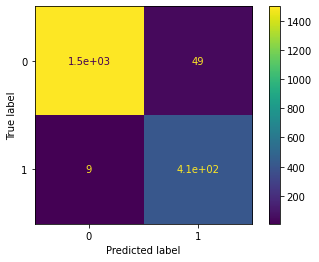

In [51]:
preds_best_xgb = grid.best_estimator_.predict(norm_test_f)
print(classification_report(y_test, preds_best_xgb))
print(confusion_matrix(y_test, preds_best_xgb))
plot_confusion_matrix(grid.best_estimator_, norm_test_f, y_test)

The results show that this tuned classifier provide good results if we care about missclassifying classes, flagging only 49 cases out of 1547 as FRAUD, when they were not actually FRAUD, and flagging 9 cases out of 422 as NON-FRAUD, when they were actually fraud.

Even so, the FALSE NEGATIVES values, those that we care more about, seem to be  higher than were with the untruned XGBClassifier, but the untuned model, flagged a high values of actually NON-FRAUD cases (110) as FRAUD.

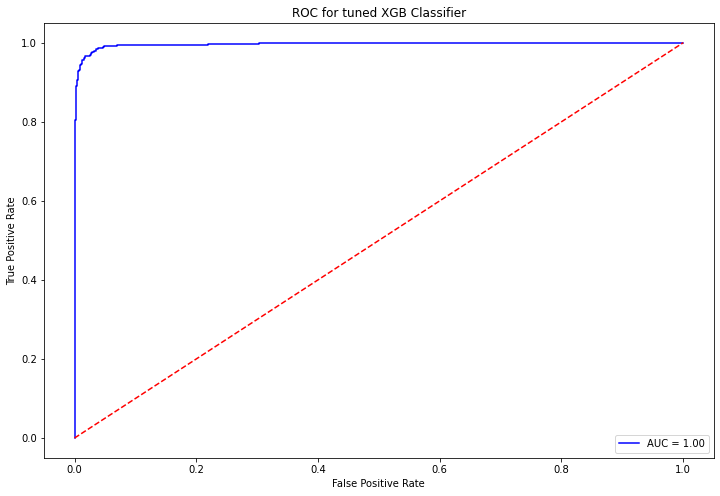

In [52]:
# Plotting AUC for tuned XGB Classifier
probs = grid.best_estimator_.predict_proba(norm_test_f)
pred = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('ROC for tuned XGB Classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [54]:
# Save the model for further use
pickle_out = open('XGB_FRAUD.pickle', 'wb')
pickle.dump(grid.best_estimator_, pickle_out)
pickle_out.close()